# Exploritory Data Analysis

## Setup

In [1]:
import gc
import pathlib 

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import preprocessing

### Reading data

### Combined dataset

In [2]:
combined_data_path = pathlib.Path.cwd().parent / 'datasets/raw' / 'combined.parquet'

In [3]:
data_df = pd.read_parquet(combined_data_path)

### Source 1 feature description

In [4]:
source_1_description_df: pd.DataFrame = pd.read_html('../datasets/raw/source_1/readme.html', skiprows=5)[0]

source_1_description_df.columns = ['Name', 'Description']
source_1_description_df = source_1_description_df.set_index('Name', drop=True)
source_1_description_df

,Description
Name,
Year,Year
Quarter,Quarter (1-4)
Month,Month
DayofMonth,Day of Month
DayOfWeek,Day of Week
...,...
Div5TotalGTime,Total Ground Time Away from Gate at Diverted A...
Div5LongestGTime,Longest Ground Time Away from Gate at Diverted...
Div5WheelsOff,Wheels Off Time (local time: hhmm) at Diverted...


### Source 2 feature description

In [5]:
source_2_description_df: pd.DataFrame = pd.read_csv("../datasets/raw/source_2/variable-descriptions.csv", skiprows=2, index_col=0, usecols=['Name', 'Description'])
source_2_description_df

,Description
Name,
Year,1987-2008
Month,12-Jan
DayofMonth,31-Jan
DayOfWeek,1 (Monday) - 7 (Sunday)
DepTime,"actual departure time (local, hhmm)"
CRSDepTime,"scheduled departure time (local, hhmm)"
ArrTime,"actual arrival time (local, hhmm)"
CRSArrTime,"scheduled arrival time (local, hhmm)"
UniqueCarrier,unique carrier code


### Handle missing values

In [6]:
perc_empty: pd.Series = preprocessing.percentage_missing_values_per_column(data_df)
print(perc_empty[perc_empty > 0])

AirTime              27.030472
TaxiIn               25.730429
TaxiOut              25.718116
Tail_Number          25.395022
ArrDelay              2.261258
ActualElapsedTime     2.260889
ArrTime               2.220742
DepDelay              2.021100
DepTime               2.020133
Distance              0.136387
OriginState           0.027382
OriginCityName        0.027382
DestCityName          0.026189
DestState             0.026189
CRSElapsedTime        0.017433
dtype: float64


AirTime, TaxiIn, TaxiOut and Tail_Number features have a high rate of missing values. We delete these columns.

In [7]:
data_df.drop(['AirTime', 'TaxiIn', 'TaxiOut', 'Tail_Number'], axis=1, inplace=True)

The remaining columns contain very few samples with missing values, since we have more than a 100 million rows we just remove the rows with missing values.

In [8]:
perc_empty: pd.Series = preprocessing.percentage_missing_values_per_column(data_df)
print(perc_empty[perc_empty > 0])

ArrDelay             2.261258
ActualElapsedTime    2.260889
ArrTime              2.220742
DepDelay             2.021100
DepTime              2.020133
Distance             0.136387
OriginState          0.027382
OriginCityName       0.027382
DestState            0.026189
DestCityName         0.026189
CRSElapsedTime       0.017433
dtype: float64


In [9]:
data_df.dropna(inplace=True)

### Limit the minimum of arrival and departure delays to be 0

In [10]:
data_df['ArrDelay'] = data_df['ArrDelay'].apply(lambda x: 0 if x < 0 else x)
data_df['DepDelay'] = data_df['DepDelay'].apply(lambda x: 0 if x < 0 else x)

### Convert types

In [11]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144482939 entries, 0 to 148108239
Data columns (total 22 columns):
 #   Column             Dtype   
---  ------             -----   
 0   Airline            category
 1   Origin             category
 2   Year               int64   
 3   Distance           float64 
 4   Cancelled          bool    
 5   DestState          category
 6   ActualElapsedTime  float64 
 7   OriginState        category
 8   ArrTime            float64 
 9   DestCityName       category
 10  CRSElapsedTime     float64 
 11  DepTime            float64 
 12  DepDelay           float64 
 13  Diverted           bool    
 14  CRSArrTime         int64   
 15  DayOfWeek          int64   
 16  OriginCityName     category
 17  ArrDelay           float64 
 18  Dest               category
 19  Month              int64   
 20  CRSDepTime         int64   
 21  DayofMonth         int64   
dtypes: bool(2), category(7), float64(7), int64(6)
memory usage: 16.8 GB


In [12]:
float_columns: pd.Index = data_df.select_dtypes(include=['float']).columns

for column in float_columns:
    if (data_df[column] == data_df[column].astype('int64')).all():
        data_df[column] = data_df[column].astype('int64')

### Convert int columns to fewer byte ints

In [13]:
integer_columns: pd.Index = data_df.select_dtypes(include=['int']).columns

for column in integer_columns:
    max_size = data_df[column].max()
    min_size = data_df[column].min()

    
    if min_size >= 0:
        if max_size <= np.iinfo(np.uint8).max:
            data_df[column] = data_df[column].astype('uint8')
        elif max_size <= np.iinfo(np.uint16).max:
            data_df[column] = data_df[column].astype('uint16')
        elif max_size <= np.iinfo(np.uint32).max:
            data_df[column] = data_df[column].astype('uint32')
        elif max_size <= np.iinfo(np.uint64).max:
            data_df[column] = data_df[column].astype('uint64')
    else:
        if max_size <= np.iinfo(np.int8).max and min_size >= np.iinfo(np.int8).min: 
            data_df[column] = data_df[column].astype('int8')
        elif max_size <= np.iinfo(np.int16).max and min_size >= np.iinfo(np.int16).min:
            data_df[column] = data_df[column].astype('int16')
        elif max_size <= np.iinfo(np.int32).max and min_size >= np.iinfo(np.int32).min:
            data_df[column] = data_df[column].astype('int32')
        elif max_size <= np.iinfo(np.int64).max and min_size >= np.iinfo(np.int64).min:
            data_df[column] = data_df[column].astype('int64')

In [14]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144482939 entries, 0 to 148108239
Data columns (total 22 columns):
 #   Column             Dtype   
---  ------             -----   
 0   Airline            category
 1   Origin             category
 2   Year               uint16  
 3   Distance           uint16  
 4   Cancelled          bool    
 5   DestState          category
 6   ActualElapsedTime  int16   
 7   OriginState        category
 8   ArrTime            uint16  
 9   DestCityName       category
 10  CRSElapsedTime     int16   
 11  DepTime            uint16  
 12  DepDelay           uint16  
 13  Diverted           bool    
 14  CRSArrTime         uint16  
 15  DayOfWeek          uint8   
 16  OriginCityName     category
 17  ArrDelay           uint16  
 18  Dest               category
 19  Month              uint8   
 20  CRSDepTime         uint16  
 21  DayofMonth         uint8   
dtypes: bool(2), category(7), int16(2), uint16(8), uint8(3)
memory usage: 5.9 GB


## Exploration

### Distribution of delays

In [15]:
quantile: float = 0.95
delay_90_percentile = data_df[['ArrDelay', 'DepDelay']].quantile(quantile)
delay_90_percentile

ArrDelay    58.0
DepDelay    54.0
Name: 0.95, dtype: float64

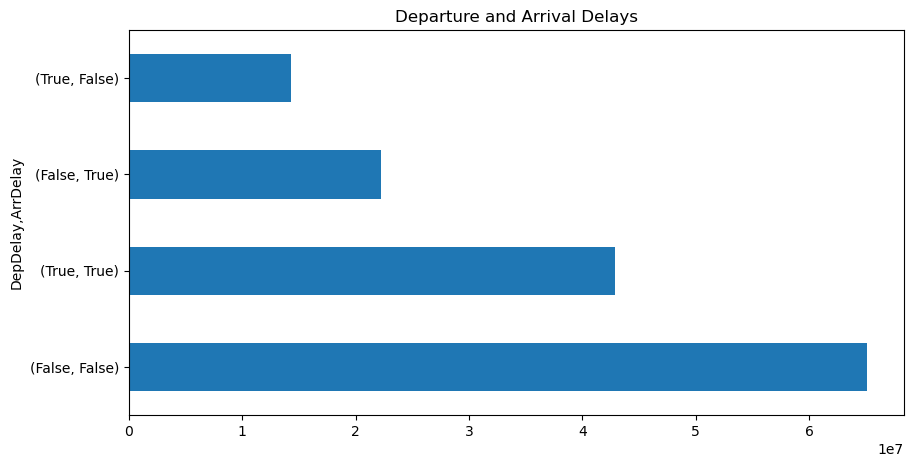

In [16]:
delays = data_df[['DepDelay', 'ArrDelay']].dropna()
delayed = (delays > 0).value_counts()
delayed.plot(kind='barh', title='Departure and Arrival Delays', figsize=(10, 5))
plt.savefig('figures/DepAndArrDelays.png')

/var/folders/c9/24l9wbvn7_l_zt25742x5qf40000gn/T/ipykernel_16788/576830492.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  sns.displot(delays[delays <= delay_90_percentile]['ArrDelay'], bins=50, kde=False).set(title='Arrival Delay Distribution')


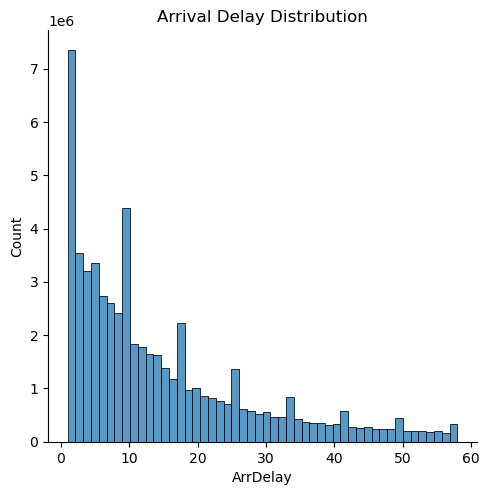

In [17]:
delays = delays[delays > 0]
sns.displot(delays[delays <= delay_90_percentile]['ArrDelay'], bins=50, kde=False).set(title='Arrival Delay Distribution')
plt.savefig('figures/ArrDelayDistribution.png')

/var/folders/c9/24l9wbvn7_l_zt25742x5qf40000gn/T/ipykernel_16788/1411447569.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  sns.displot(delays[delays <= delay_90_percentile]['DepDelay'], bins=50, kde=False).set(title='Departure Delay Distribution')


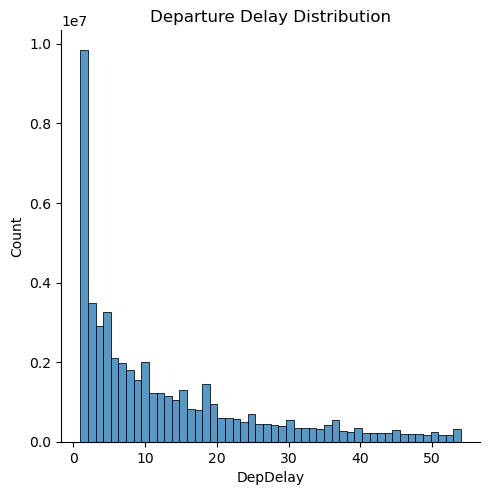

In [18]:
sns.displot(delays[delays <= delay_90_percentile]['DepDelay'], bins=50, kde=False).set(title='Departure Delay Distribution')
plt.savefig('figures/DepDelayDistribution.png')

### Distribution of flights

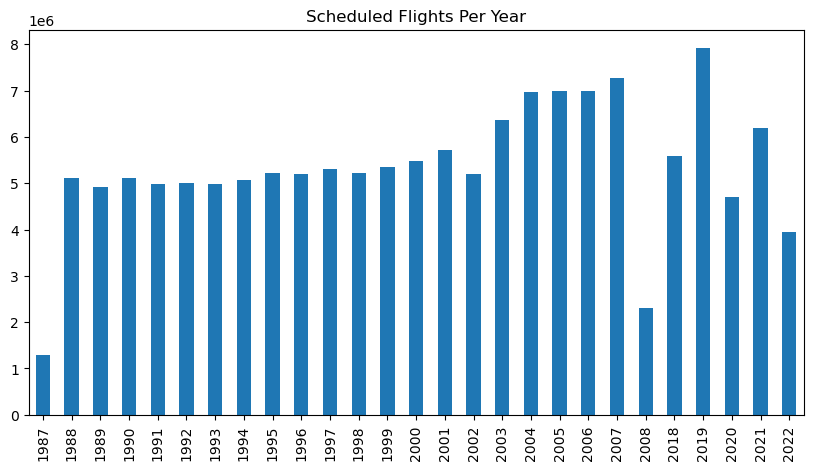

In [19]:
data_df['Year'].value_counts().sort_index().plot(kind="bar", figsize=(10, 5), title="Scheduled Flights Per Year", stacked=True)
plt.savefig('figures/FlightCountPerYear.png')

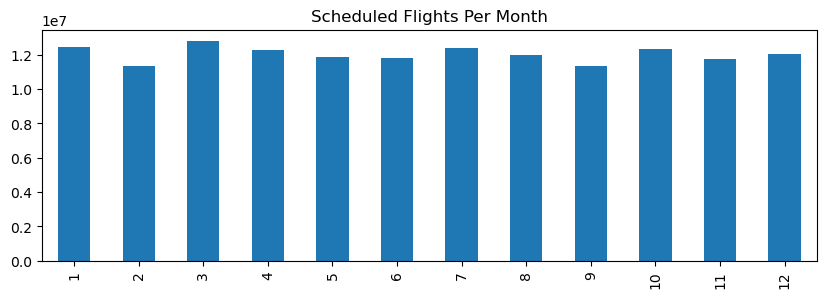

In [20]:
data_df['Month'].value_counts().sort_index().plot(kind="bar", figsize=(10, 3), title="Scheduled Flights Per Month")
plt.savefig('figures/FlightCountPerMonth.png')

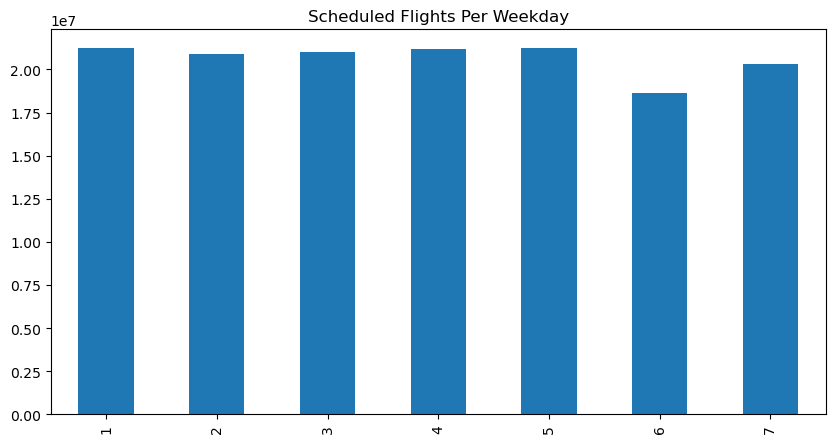

In [21]:
data_df['DayOfWeek'].value_counts().sort_index().plot(kind="bar", figsize=(10, 5), title="Scheduled Flights Per Weekday")
plt.savefig('figures/FlightCountPerWeekday.png')

In [22]:
# 2   Cancelled          2000 non-null   int64   
#  3   Diverted           2000 non-null   int64   
#  4   CRSDepTime         2000 non-null   int64   
#  5   DepTime            1928 non-null   float64 
#  6   DepDelay           1912 non-null   float64 
#  7   ArrTime            1927 non-null   float64 
#  8   AirTime            1345 non-null   float64 
#  9   CRSElapsedTime     2000 non-null   float64 
#  10  ActualElapsedTime  1927 non-null   float64 
#  11  Distance           2000 non-null   float64 
#  22  CRSArrTime         2000 non-null   int64   
#  23  ArrDelay           1906 non-null   float64
# sns.pairplot(data_df[['ArrDelay', 'DepDelay']], diag_kind='hist', corner=False)

### Correlation Matrix

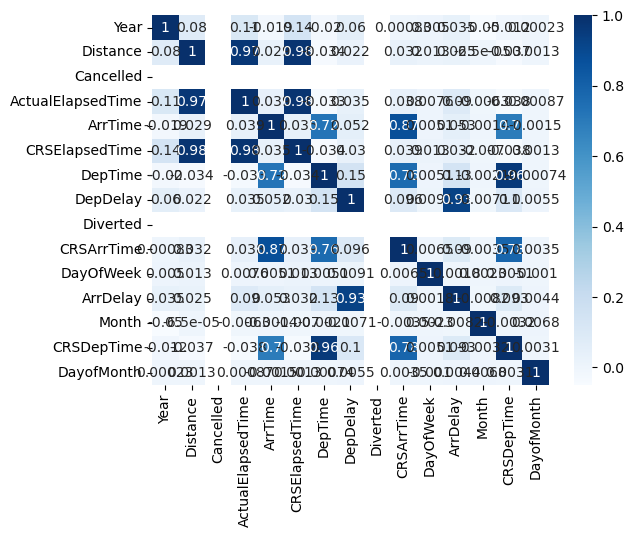

In [23]:
cm = data_df.corr(numeric_only=True)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.savefig('figures/CorrelationMatrix.png')

### Corona impact on delays

In this section we aim to improve our understanding of how the policies to reduce the spread of the corona virus in its earlier stages affected the aviation industry with respect to flights and delays.


<Axes: title={'center': 'Scheduled Flights Per Month'}, xlabel='Year'>

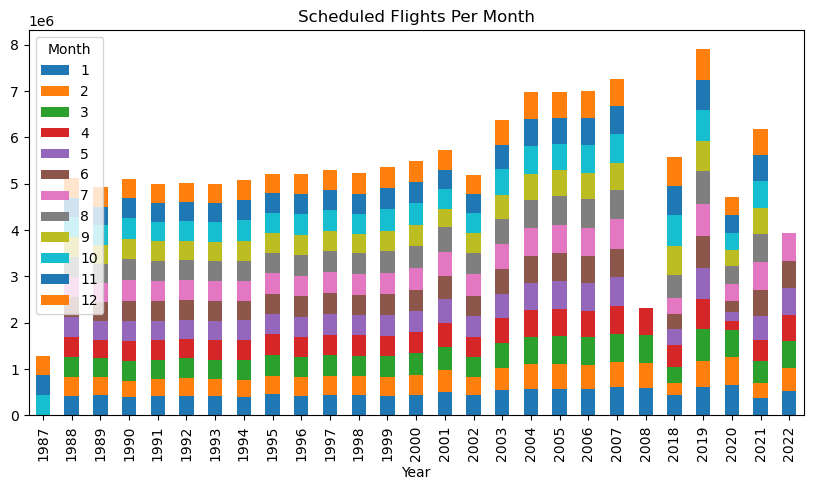

In [24]:
data_df.groupby(['Year', 'Month']).size().unstack().plot(kind='bar', figsize=(10, 5), title='Scheduled Flights Per Month', stacked=True)

<Axes: title={'center': 'Average Arrival Delay Per Month'}, xlabel='Year'>

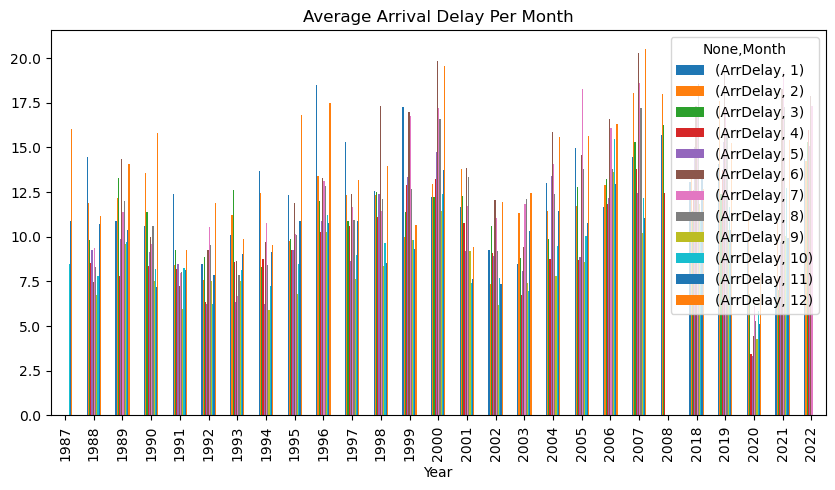

In [25]:
data_df.groupby(['Year', 'Month'])[['ArrDelay']].mean().unstack().plot(kind='bar', figsize=(10, 5), title='Average Arrival Delay Per Month')

### Average monthly flights for pre-pandemic, during the pandemic, and post-pandemic

We define 2020 as the pandemic year. This is the year that traveling restrictions went into affect...

In [48]:
pre_pandemic: pd.DataFrame = data_df[data_df['Year'] < 2020]
pandemic: pd.DataFrame = data_df[data_df['Year'] == 2020]
post_pandemic: pd.DataFrame = data_df[data_df['Year'] > 2020]

In [ ]:
pre_pandemic: pd.DataFrame = data_df[data_df['Year'] == 2019]
pandemic: pd.DataFrame = data_df[data_df['Year'] == 2020]
post_pandemic: pd.DataFrame = data_df[data_df['Year'] == 2021]

Year  Month
2021  1        374609
      2        329273
      3        460415
      4        470609
      5        516390
      6        562669
      7        603149
      8        590586
      9        559156
      10       581633
      11       572369
      12       565012
2022  1        526894
      2        495651
      3        579953
      4        565501
      5        589376
      6        581836
      7        605705
Name: Airline, dtype: int64

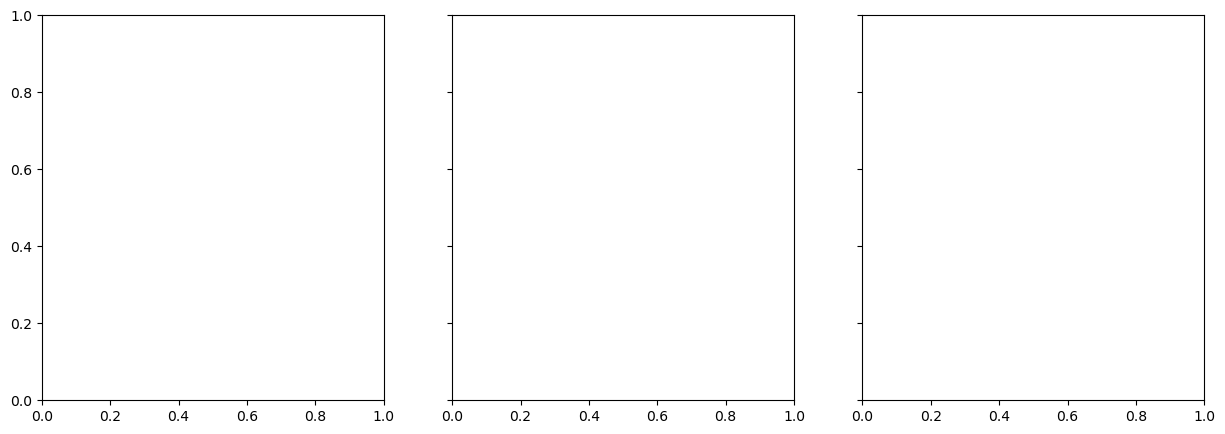

In [55]:
_, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
pre_pandemic.groupby(['Year', 'Month'])['Airline'].count() #.plot(kind='bar', ax=axes[0], title='Scheduled Flights Per Month (Pre-Pandemic)')
pandemic.groupby(['Year', 'Month'])['Airline'].count() #.plot(kind='bar', ax=axes[1], title='Scheduled Flights Per Month (Pandemic)')
post_pandemic.groupby(['Year', 'Month'])['Airline'].count() #.plot(kind='bar', ax=axes[2], title='Scheduled Flights Per Month (Post-Pandemic)')
#1     450751.5


### Corrlation matrix

<Axes: >

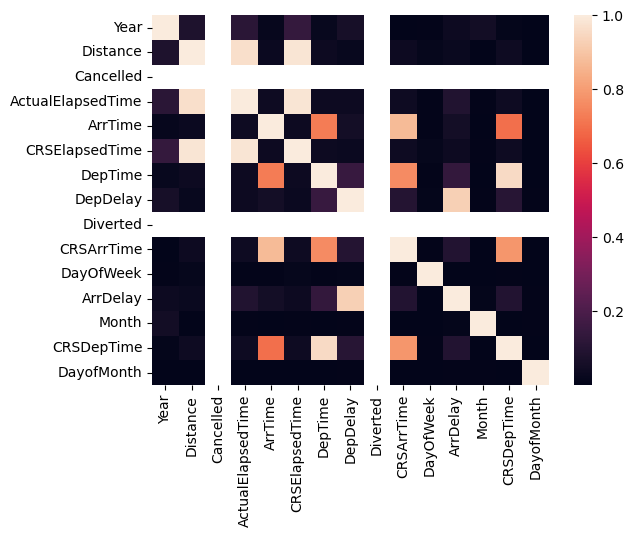

In [26]:
sns.heatmap(data_df.corr(numeric_only=True).abs())